In [1]:
%pip install -q python-dotenv langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

query = '인프런에는 어떤 강의가 있나요?'

llm = ChatOpenAI(model='gpt-4o')
llm.invoke(query)


AIMessage(content='인프런은 다양한 주제와 분야에 걸쳐 많은 온라인 강의를 제공하는 플랫폼입니다. 대표적인 강의 주제는 다음과 같습니다:\n\n1. **프로그래밍**: 파이썬, 자바스크립트, 자바, C++, 자료구조 및 알고리즘 등 다양한 프로그래밍 언어와 주제를 다룹니다.\n2. **웹 개발**: HTML, CSS, React, Vue.js, Angular 등 프런트엔드 및 백엔드 웹 개발 기술.\n3. **데이터 과학 및 AI**: 데이터 분석, 머신러닝, 딥러닝, 텐서플로우, 파이토치 등.\n4. **모바일 개발**: 안드로이드, iOS 개발, React Native, 플러터 등.\n5. **클라우드 및 DevOps**: AWS, Azure, Docker, Kubernetes 등 클라우드 서비스와 DevOps 툴 관련 강의.\n6. **디자인**: UX/UI 디자인, 그래픽 디자인, 포토샵, 일러스트레이터 등.\n7. **비즈니스 및 마케팅**: 디지털 마케팅, SEO, 경영, 창업 등.\n8. **자기 개발**: 생산성 향상, 시간 관리, 커리어 개발 등.\n\n강의는 초급부터 고급까지 다양한 난이도로 제공되며, 각 분야의 전문가들이 강의를 진행합니다. 인프런 웹사이트에서 상세한 강의 목록과 강사의 정보를 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 324, 'prompt_tokens': 18, 'total_tokens': 342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 

In [3]:
# Rag의 목적 = 사용자의 질문에 답변하기 위해 질문과 관련된 청크(retrieve)를 생성하고, 생성된 청크를 기반으로 답변을 생성하고, 생성된 답변을 사용자에게 전달하는 것
#  State = 현재 Agent의 상태
# Node = Agent가 수행하는 작업
# Edge = Node들의 관계 (실선일 경우, 반드시 발생하는 관계, 점선일 경우, 선택적인 관계)
# Conditional Edge = 조건부 관계 (조건이 만족되면, 실선의 Edge로 전환)

In [4]:
%pip install -q langgraph

Note: you may need to restart the kernel to use updated packages.


In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

# AnyMessage: Agent가 출력하는 모든 메시지의 부모 클래스
# SystemMessage: LLM(언어 모델) 기반의 대화형 응용프로그램(예: 챗봇)에서 대화의 맥락이나 규칙을 정해주는 특별한 메시지
# HumanMessage: 사용자가 입력한 메시지
# AgentMessage: Agent가 출력한 메시지

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]


In [6]:
from langgraph.graph import StateGraph

# Node: Agent가 수행하는 작업
# Edge: Node들의 관계

graph_builder = StateGraph(AgentState)

In [7]:
def generate(state: AgentState) -> AgentState:
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}

In [8]:
from langgraph.graph import START, END
graph_builder.add_node('generate', generate)
graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)

In [9]:
graph = graph_builder.compile()

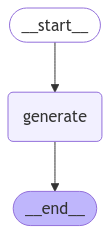

In [10]:
from IPython.display import display, Image

# 내가 생성한 Agent의 State Graph를 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import HumanMessage

initial_state = {'messages': [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [AIMessage(content='인프런은 다양한 주제에 대한 온라인 강의를 제공하는 플랫폼입니다. 주요 카테고리로는 다음과 같은 것들이 있습니다:\n\n1. **프로그래밍 및 개발**: Python, Java, JavaScript, C++, 웹 개발, 모바일 애플리케이션 개발 등 다양한 프로그래밍 언어와 기술에 대한 강의가 있습니다.\n\n2. **데이터 사이언스 및 AI**: 데이터 분석, 머신러닝, 딥러닝, 인공지능 등의 과정을 통해 데이터 관련 기술을 학습할 수 있습니다.\n\n3. **디자인**: 그래픽 디자인, UX/UI 디자인, Photoshop, Illustrator 등을 다루는 강의가 있습니다.\n\n4. **비즈니스 및 마케팅**: 비즈니스 전략, 디지털 마케팅, SEO, 소셜 미디어 마케팅 등을 배우는 강의가 포함되어 있습니다.\n\n5. **자기계발**: 생산성 향상, 리더십, 스피치 및 프레젠테이션 스킬 등 개인 역량 강화를 위한 강의도 제공됩니다.\n\n6. **기타**: 음악, 사진, 취미 생활 등의 다양한 주제에 대한 강의도 있습니다.\n\n각 카테고리 안에는 초급부터 고급 수준까지 다양한 난이도의 강의가 있어, 자신의 수준에 맞게 학습할 수 있습니다. 최신 강의 목록은 인프런 웹사이트를 방문하여 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 304, 'prompt_tokens': 18, 'total_tokens': 322, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_t